In [9]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import retrieve
from pathlib import Path

In [11]:
# data_file = maybe_download("apthunt")
data_file = retrieve.maybe_download("apthunt")

segment 3/4 completed
segment 2/4 completed
segment 1/4 completed
segment 0/4 completed
Pickling apthunt.pkl.


In [12]:
data = pickle.load(open(data_file, 'rb'))

In [13]:
print("wow")

wow


In [14]:
df = pd.DataFrame(data)

In [15]:
del data

In [16]:
with open("df.pkl", 'wb') as f:
    pickle.dump(df, f, pickle.HIGHEST_PROTOCOL)

In [18]:
df.shape

(1266986, 35)

In [19]:
df

,parsed_map_address,parsed_postingtitletext,added,PostUrl,PostTitle,parsed_price,parsed_price_text,parsed_housing,PostContent,parsed_data_longitude,...,parsed_area,parsed_furnished,parsed_wd,parsed_type,parsed_laundryb,parsed_nthumbs,parsed_garagea,parsed_laundrys,parsed_garaged,parsed_catsok
0,reed near timberpine,$2895 / 2br - 1000ft2 - Luxury 2beds (private ...,1586943009425,https://sfbay.craigslist.org/sby/apa/d/sunnyva...,simulated,2895,$2895,2br - 1000ft2,simulated,-121.99987,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3110 Casa De Campo,"$1,995 / 550ft2 - Move In Special! 6 WEEKS FRE...",1600492989288,https://sfbay.craigslist.org/pen/apa/d/san-mat...,NaN,1995,"$1,995",550ft2,NaN,-122.285547,...,550,False,True,apartment,False,3,False,False,False,True
2,150 Caldecott Lane #3 near Tunnel Road,$3297 / 3br - 1700ft2 - 3Bed 2Bath Claremont H...,1594826706728,https://sfbay.craigslist.org/eby/apa/d/oakland...,NaN,3297,$3297,3br - 1700ft2,NaN,-122.223458,...,1700,False,False,apartment,False,10,False,False,False,True
3,333 Harrison St. near Fremont St.,$3300 / 560ft2 - Generously Sized Studio Home ...,1576459291763,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,simulated,3300,$3300,560ft2,simulated,-122.391465,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2232 Haste ST near Ellsworth ST,$1895 / 1br - NICE ONE BEDROOM APT OPEN HOUSES...,1592637973617,https://sfbay.craigslist.org/eby/apa/d/berkele...,NaN,1895,$1895,1br,NaN,-122.257,...,None,False,False,apartment,False,0,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1266981,2118 CANOAS GARDEN AVE near ALMADEN RD,$2395 / 2br - 820ft2 - BEAUTIFUL WILLOW GLEN H...,1590758748428,https://sfbay.craigslist.org/sby/apa/d/san-jos...,simulated,2395,$2395,2br - 820ft2,simulated,-121.878835,...,820,False,False,apartment,False,9,False,True,False,True
1266982,(google map),$800 / 1br - Gorgeous apartment one Bed**One B...,1580296830052,https://sfbay.craigslist.org/sfc/apa/d/daly-ci...,simulated,800,$800,1br,simulated,-122.4619,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1266983,537 Fillmore Street near Fell,$4100 / 2br - 2 BR 1 Bath Light Filled Edwardi...,1574324532640,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,simulated,4100,$4100,2br,simulated,-122.430894,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1266984,2111 Kawana Springs Road,"$1895 / 1br - 716ft2 - Quartz Countertops, Soo...",1573041479847,https://sfbay.craigslist.org/nby/apa/d/santa-r...,simulated,1895,$1895,1br - 716ft2,simulated,-122.687097,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## can restore from here

In [20]:
df = pickle.load(open("df.pkl", 'rb'))

In [21]:
df.head()

,parsed_map_address,parsed_postingtitletext,added,PostUrl,PostTitle,parsed_price,parsed_price_text,parsed_housing,PostContent,parsed_data_longitude,...,parsed_area,parsed_furnished,parsed_wd,parsed_type,parsed_laundryb,parsed_nthumbs,parsed_garagea,parsed_laundrys,parsed_garaged,parsed_catsok
0,reed near timberpine,$2895 / 2br - 1000ft2 - Luxury 2beds (private ...,1586943009425,https://sfbay.craigslist.org/sby/apa/d/sunnyva...,simulated,2895,$2895,2br - 1000ft2,simulated,-121.99987,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3110 Casa De Campo,"$1,995 / 550ft2 - Move In Special! 6 WEEKS FRE...",1600492989288,https://sfbay.craigslist.org/pen/apa/d/san-mat...,NaN,1995,"$1,995",550ft2,NaN,-122.285547,...,550,False,True,apartment,False,3,False,False,False,True
2,150 Caldecott Lane #3 near Tunnel Road,$3297 / 3br - 1700ft2 - 3Bed 2Bath Claremont H...,1594826706728,https://sfbay.craigslist.org/eby/apa/d/oakland...,NaN,3297,$3297,3br - 1700ft2,NaN,-122.223458,...,1700,False,False,apartment,False,10,False,False,False,True
3,333 Harrison St. near Fremont St.,$3300 / 560ft2 - Generously Sized Studio Home ...,1576459291763,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,simulated,3300,$3300,560ft2,simulated,-122.391465,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2232 Haste ST near Ellsworth ST,$1895 / 1br - NICE ONE BEDROOM APT OPEN HOUSES...,1592637973617,https://sfbay.craigslist.org/eby/apa/d/berkele...,NaN,1895,$1895,1br,NaN,-122.257,...,None,False,False,apartment,False,0,False,True,False,False


In [22]:
# small cleanup of "simulated"
del df["FeedTitle"]
del df["FeedUrl"]
del df["PostContent"]
del df["PostPublished"]
del df["PostTitle"]
# delete parsed_notices. looks like it is the same
del df["parsed_notices"]
# no need for price text
del df["parsed_price_text"]

In [23]:
df.columns

Index(['parsed_map_address', 'parsed_postingtitletext', 'added', 'PostUrl',
       'parsed_price', 'parsed_housing', 'parsed_data_longitude',
       'parsed_attrs', 'parsed_district', 'parsed_map_link', 'parsed_bedrooms',
       'parsed_postingbody', 'parsed_page_head', 'parsed_thumbs', 'intid',
       'parsed_titletextonly', 'parsed_data_latitude', 'parsed_dogsok',
       'parsed_area', 'parsed_furnished', 'parsed_wd', 'parsed_type',
       'parsed_laundryb', 'parsed_nthumbs', 'parsed_garagea',
       'parsed_laundrys', 'parsed_garaged', 'parsed_catsok'],
      dtype='object')

In [24]:
def clean_parsed_args(args):
    if not isinstance(args, list):
        return []
    clean = []
    for p in args:
        # remove days
        if p.startswith("friday") or p.startswith("monday") or p.startswith("saturday") or p.startswith("sunday") or p.startswith("thursday") or p.startswith("tuesday") or p.startswith("wednesday"):
            continue
        # remove br/ba
        if "BR / " in p: continue
        # remove ft2
        if p.endswith("ft2"): continue

        # remove application fee
        if p.startswith("application fee"): continue
        
        # remove broker fee
        if p.startswith("broker fee"): continue
        
        # remove available
        if p.startswith("available"): continue
        
        # remove listed by
        if p.startswith("listed by"): continue
        clean.append(p)
    return clean
        

In [25]:
df['parsed_attrs'] = df['parsed_attrs'].map(clean_parsed_args)
# one_hot = pd.get_dummies(df['parsed_attrs'])

In [26]:
df['parsed_attrs']

0                  [apartment, w/d in unit, attached garage]
1          [cats are OK - purrr, dogs are OK - wooof, apa...
2          [cats are OK - purrr, dogs are OK - wooof, apa...
3                  [apartment, w/d in unit, attached garage]
4          [apartment, laundry on site, no smoking, off-s...
                                 ...                        
1266981    [cats are OK - purrr, dogs are OK - wooof, apa...
1266982    [cats are OK - purrr, dogs are OK - wooof, apa...
1266983    [cats are OK - purrr, apartment, laundry in bl...
1266984                                          [apartment]
1266985    [cats are OK - purrr, dogs are OK - wooof, apa...
Name: parsed_attrs, Length: 1266986, dtype: object

In [27]:
df.head()

,parsed_map_address,parsed_postingtitletext,added,PostUrl,parsed_price,parsed_housing,parsed_data_longitude,parsed_attrs,parsed_district,parsed_map_link,...,parsed_area,parsed_furnished,parsed_wd,parsed_type,parsed_laundryb,parsed_nthumbs,parsed_garagea,parsed_laundrys,parsed_garaged,parsed_catsok
0,reed near timberpine,$2895 / 2br - 1000ft2 - Luxury 2beds (private ...,1586943009425,https://sfbay.craigslist.org/sby/apa/d/sunnyva...,2895,2br - 1000ft2,-121.99987,"[apartment, w/d in unit, attached garage]",sunnyvale,"https://www.google.com/maps/search/37.366541,-...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3110 Casa De Campo,"$1,995 / 550ft2 - Move In Special! 6 WEEKS FRE...",1600492989288,https://sfbay.craigslist.org/pen/apa/d/san-mat...,1995,550ft2,-122.285547,"[cats are OK - purrr, dogs are OK - wooof, apa...",san mateo,"https://www.google.com/maps/search/37.543434,-...",...,550,False,True,apartment,False,3,False,False,False,True
2,150 Caldecott Lane #3 near Tunnel Road,$3297 / 3br - 1700ft2 - 3Bed 2Bath Claremont H...,1594826706728,https://sfbay.craigslist.org/eby/apa/d/oakland...,3297,3br - 1700ft2,-122.223458,"[cats are OK - purrr, dogs are OK - wooof, apa...",oakland rockridge / claremont,"https://www.google.com/maps/search/37.853678,-...",...,1700,False,False,apartment,False,10,False,False,False,True
3,333 Harrison St. near Fremont St.,$3300 / 560ft2 - Generously Sized Studio Home ...,1576459291763,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,3300,560ft2,-122.391465,"[apartment, w/d in unit, attached garage]",SOMA / south beach,https://www.google.com/maps/preview/@37.787230...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2232 Haste ST near Ellsworth ST,$1895 / 1br - NICE ONE BEDROOM APT OPEN HOUSES...,1592637973617,https://sfbay.craigslist.org/eby/apa/d/berkele...,1895,1br,-122.257,"[apartment, laundry on site, no smoking, off-s...",berkeley,None,...,None,False,False,apartment,False,0,False,True,False,False


In [28]:
df.shape

(1266986, 28)

In [29]:
def get_type(attrs):
    if not isinstance(attrs, list):
        return None
    types = set([
        "apartment", 
        "townhouse", 
        "loft", 
        "land", 
        "house", 
        "duplex", 
        "flat", 
        "condo", 
        "cottage/cabin"
    ])
    return ",".join(sorted(types & set(attrs)))

In [30]:
def prepare_data(df):
    new  = pd.DataFrame()
    new["PostUrl"] = df["PostUrl"]
    new["latitude"] = df["parsed_data_latitude"]
    new["longitude"] = df["parsed_data_longitude"]
    new["district"] = df["parsed_district"].map(lambda s: s.strip("()") if isinstance(s, str) else s)
    new["address"] = df["parsed_map_address"].map(lambda x: x if x != "(google map)" else None)
    new["housing"] = df["parsed_housing"]
    
    new["price"] = df["parsed_price"].map(lambda x: float(x) if x else x)
    
    # to numerical values
    new['price'] = pd.to_numeric(new['price'])
    new['longitude'] = pd.to_numeric(new['longitude'])
    new['latitude'] = pd.to_numeric(new['latitude'])
    
    new['bedrooms'] = new['housing'].str.extract('(\d+)br.*', expand=True)
    new['bedrooms'] = pd.to_numeric(new['bedrooms'])
    
    new['area'] = new['housing'].str.extract('(\d+)ft2', expand=True)
    new['area'] = pd.to_numeric(new['area'])
    
    new['type'] = df["parsed_attrs"].map(get_type)
    new['catsok'] = df["parsed_attrs"].map(lambda x: "cats are OK - purrr" in x)
    new['dogsok'] = df["parsed_attrs"].map(lambda x: "dogs are OK - wooof" in x)
    new['garagea'] = df["parsed_attrs"].map(lambda x: "attached garage" in x)
    new['garaged'] = df["parsed_attrs"].map(lambda x: "detached garage" in x)
    new['furnished'] = df["parsed_attrs"].map(lambda x: "furnished" in x)
    
    new['laundryb'] = df["parsed_attrs"].map(lambda x: "laundry in bldg" in x)
    new['laundrys'] = df["parsed_attrs"].map(lambda x: "laundry on site" in x)
    
    new['wd'] = df["parsed_attrs"].map(lambda x: "w/d in unit" in x)
    new['nthumbs'] = df["parsed_thumbs"].apply(lambda x: len(x) if isinstance(x, list) else 0)

    return new

In [ ]:
short = prepare_data(df)

In [21]:
short

,PostUrl,latitude,longitude,district,address,housing,price,bedrooms,area,type,catsok,dogsok,garagea,garaged,furnished,laundryb,laundrys,wd,nthumbs
0,https://sfbay.craigslist.org/sby/apa/d/brand-n...,37.283338,-121.856790,san jose downtown,None,1br,1500.0,1.0,NaN,townhouse,False,False,True,False,False,False,False,True,7
1,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,37.803698,-122.432477,marina / cow hollow,Bay St near Laguna,None,3024.0,NaN,NaN,apartment,False,False,True,False,False,False,True,False,14
2,https://sfbay.craigslist.org/sby/apa/d/san-jos...,37.337881,-121.782015,san jose east,None,1br - 600ft2,1500.0,1.0,600.0,,False,False,True,False,False,False,False,True,11
3,https://sfbay.craigslist.org/sby/apa/d/resort-...,37.243414,-121.867368,san jose south,909 Lake Tahoe Ct,3br - 1205ft2,3259.0,3.0,1205.0,townhouse,False,False,True,False,False,False,False,True,23
4,https://sfbay.craigslist.org/sfc/apa/d/click-b...,37.788101,-122.417420,lower nob hill,1025 Sutter Street,1br,3395.0,1.0,NaN,apartment,True,True,False,False,False,False,False,True,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1151690,https://sfbay.craigslist.org/nby/apa/d/santa-r...,38.415841,-122.708745,santa rosa,2355 Meadow Way near Kawana Springs Road,1br - 686ft2,1650.0,1.0,686.0,apartment,True,True,False,False,False,True,False,False,19
1151691,https://sfbay.craigslist.org/sby/apa/d/san-jos...,37.296481,-121.878835,san jose west,2118 CANOAS GARDEN AVE near ALMADEN RD,2br - 820ft2,2395.0,2.0,820.0,apartment,True,True,False,False,False,False,True,False,9
1151692,https://sfbay.craigslist.org/sfc/apa/d/daly-ci...,37.705800,-122.461900,"San Francisco, CA",None,1br,800.0,1.0,NaN,apartment,True,True,False,False,False,False,False,False,0
1151693,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,37.774315,-122.430894,lower haight,537 Fillmore Street near Fell,2br,4100.0,2.0,NaN,apartment,True,False,False,False,False,True,False,False,12


In [22]:
short.shape

(1151695, 19)

In [23]:
short.dropna(subset=["price"], inplace=True)
short.shape

(1146740, 19)

In [24]:
short["price"].describe()

count    1.146740e+06
mean     2.616112e+14
std      2.801488e+17
min      0.000000e+00
25%      2.100000e+03
50%      2.661000e+03
75%      3.495000e+03
max      3.000000e+20
Name: price, dtype: float64

In [25]:
# change all prices more than 9k to to 9 k
short.loc[short['price'] > 10000, "price"] = 11111

In [26]:
short["price"].describe()

count    1.146740e+06
mean     2.955578e+03
std      1.401275e+03
min      0.000000e+00
25%      2.100000e+03
50%      2.661000e+03
75%      3.495000e+03
max      1.111100e+04
Name: price, dtype: float64

In [27]:
short.shape

(1146740, 19)

In [28]:
short.drop_duplicates(inplace=True)
short.shape

(772483, 19)

In [29]:
short['price_bucket'] = short['price'].apply(lambda x: f"{x//500:02.0f}x500")

In [30]:
short.head()

,PostUrl,latitude,longitude,district,address,housing,price,bedrooms,area,type,catsok,dogsok,garagea,garaged,furnished,laundryb,laundrys,wd,nthumbs,price_bucket
0,https://sfbay.craigslist.org/sby/apa/d/brand-n...,37.283338,-121.856790,san jose downtown,None,1br,1500.0,1.0,NaN,townhouse,False,False,True,False,False,False,False,True,7,03x500
1,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,37.803698,-122.432477,marina / cow hollow,Bay St near Laguna,None,3024.0,NaN,NaN,apartment,False,False,True,False,False,False,True,False,14,06x500
2,https://sfbay.craigslist.org/sby/apa/d/san-jos...,37.337881,-121.782015,san jose east,None,1br - 600ft2,1500.0,1.0,600.0,,False,False,True,False,False,False,False,True,11,03x500
3,https://sfbay.craigslist.org/sby/apa/d/resort-...,37.243414,-121.867368,san jose south,909 Lake Tahoe Ct,3br - 1205ft2,3259.0,3.0,1205.0,townhouse,False,False,True,False,False,False,False,True,23,06x500
4,https://sfbay.craigslist.org/sfc/apa/d/click-b...,37.788101,-122.417420,lower nob hill,1025 Sutter Street,1br,3395.0,1.0,NaN,apartment,True,True,False,False,False,False,False,True,12,06x500


In [31]:
short["price_bucket"].describe()

count     772483
unique        22
top       04x500
freq      163796
Name: price_bucket, dtype: object

In [34]:
export_path = Path("./apthuntdata")
export_path.mkdir(exist_ok=True)
short.to_csv(export_path/"data.csv", index=False) 

In [35]:
short["price"].describe()

count    772483.000000
mean       2958.978080
std        1372.221378
min           0.000000
25%        2100.000000
50%        2695.000000
75%        3495.000000
max       11111.000000
Name: price, dtype: float64

<AxesSubplot:xlabel='price'>

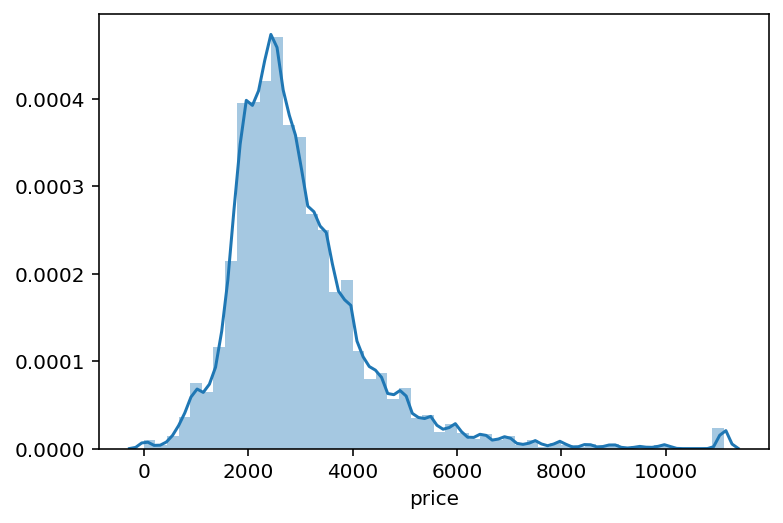

In [36]:
sns.distplot(short.loc[:, "price"])

<AxesSubplot:xlabel='price'>

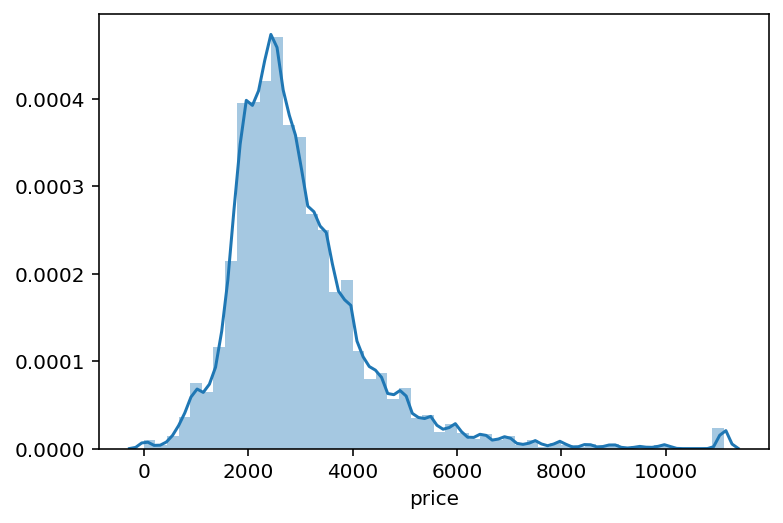

In [37]:
sns.distplot(short.loc[short["price"] < 20000, "price"])

In [38]:
short[short.price > 15000].describe()

,latitude,longitude,price,bedrooms,area,nthumbs
count,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN
